# LSTM model (long short term memory)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, matthews_corrcoef, balanced_accuracy_score, 
                             cohen_kappa_score, confusion_matrix)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
df = pd.read_csv('dataset.csv')

C:\Users\raksh\AppData\Local\Temp\ipykernel_20064\112859877.py:1: DtypeWarning: Columns (22,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


In [21]:
if 'DTC_NUMBER' in df.columns:
    df['DTC_NUMBER'] = df['DTC_NUMBER'].fillna('MIL is OFF0 codes')
    df['EngineHealth'] = df['DTC_NUMBER'].apply(lambda x: 0 if x.strip() == 'MIL is OFF0 codes' else 1)
    print("Created 'EngineHealth' column based on DTC_NUMBER.")
else:
    raise ValueError("DTC_NUMBER column not found in the dataset. Cannot create EngineHealth target.")


Created 'EngineHealth' column based on DTC_NUMBER.


In [27]:
cols_to_drop = [
    'AUTOMATIC', 'BAROMETRIC_PRESSURE(KPA)', 'FUEL_LEVEL', 'AMBIENT_AIR_TEMP', 
    'INTAKE_MANIFOLD_PRESSURE', 'MAF', 'LONG TERM FUEL TRIM BANK 2', 'FUEL_TYPE', 
    'FUEL_PRESSURE', 'SHORT TERM FUEL TRIM BANK 2', 'ENGINE_RUNTIME', 'TROUBLE_CODES', 
    'EQUIV_RATIO', 'TIMESTAMP', 'VEHICLE_ID', 'DTC_NUMBER'
]
df.drop(columns=cols_to_drop, errors='ignore', inplace=True)

In [28]:
feature_cols = [
    'MARK', 'MODEL', 'CAR_YEAR', 'ENGINE_POWER', 'ENGINE_COOLANT_TEMP', 
    'ENGINE_LOAD', 'ENGINE_RPM', 'AIR_INTAKE_TEMP', 'SPEED', 
    'SHORT TERM FUEL TRIM BANK 1', 'THROTTLE_POS', 
    'TIMING_ADVANCE', 'MIN', 'HOURS', 'DAYS_OF_WEEK', 'MONTHS', 'YEAR'
]
df_model = df[feature_cols + ['EngineHealth']].copy()
df_model.dropna(subset=['EngineHealth'], inplace=True) 

In [29]:
X = df_model[feature_cols]
y = df_model['EngineHealth']

In [31]:
# preprocess the data - preprocessing pipeline
categorical_features = ['MARK', 'MODEL']
numeric_features = [col for col in feature_cols if col not in categorical_features]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [32]:
# Split into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [33]:
#reshape the data for lstm 
# Treating each sample as a sequence with length=input_dim and 1 feature per timestep.

input_dim = X_train_processed.shape[1]
X_train_lstm = np.expand_dims(X_train_processed, axis=-1)  # shape: (n_samples, input_dim, 1)
X_test_lstm = np.expand_dims(X_test_processed, axis=-1)


## Model 

In [36]:
model_lstm = Sequential([
    LSTM(64, input_shape=(input_dim, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='sigmoid')  # Sigmoid activation for binary classification.
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### training the model

In [37]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_lstm = model_lstm.fit(
    X_train_lstm, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.8736 - loss: 0.2927 - val_accuracy: 0.8682 - val_loss: 0.3029
Epoch 2/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.8746 - loss: 0.2905 - val_accuracy: 0.8682 - val_loss: 0.3010
Epoch 3/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9211 - loss: 0.1814 - val_accuracy: 0.9972 - val_loss: 0.0144
Epoch 4/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9978 - loss: 0.0125 - val_accuracy: 0.9975 - val_loss: 0.0126
Epoch 5/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9978 - loss: 0.0117 - val_accuracy: 0.9975 - val_loss: 0.0137
Epoch 6/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9974 - loss: 0.0119 - val_accuracy: 0.9971 - val_loss: 0.0138
Epoch 7/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.9975 - loss: 0.0126 - val_accuracy: 0.9970 - val_loss: 0.0129
Epoch 8/10
951/951 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.9978 - loss: 0.0109 - 

### Evaluation of the model

297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9969 - loss: 0.0067
LSTM Test Loss: 0.0081, LSTM Test Accuracy: 0.9966
297/297 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


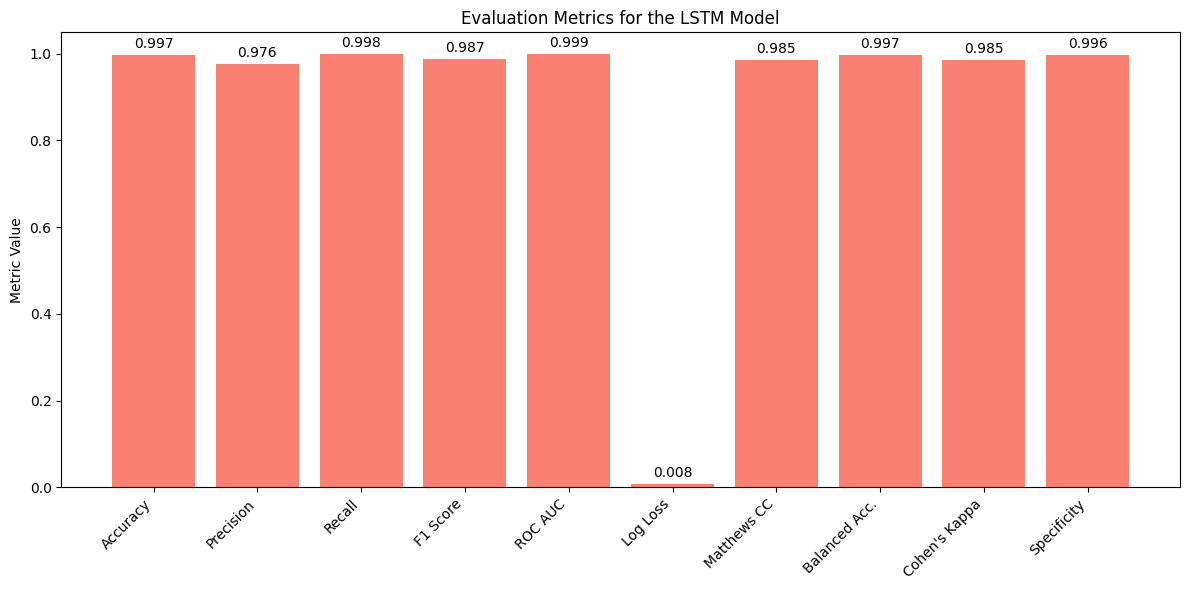

In [40]:
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test_lstm, y_test)
print(f'LSTM Test Loss: {test_loss_lstm:.4f}, LSTM Test Accuracy: {test_accuracy_lstm:.4f}')
y_pred_proba_lstm = model_lstm.predict(X_test_lstm)
y_pred_lstm = (y_pred_proba_lstm >= 0.5).astype(int).flatten()
# 1. Accuracy
acc = accuracy_score(y_test, y_pred_lstm)
# 2. Precision
prec = precision_score(y_test, y_pred_lstm)
# 3. Recall
rec = recall_score(y_test, y_pred_lstm)
# 4. F1 Score
f1 = f1_score(y_test, y_pred_lstm)
# 5. ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba_lstm)
# 6. Log Loss
ll = log_loss(y_test, y_pred_proba_lstm)
# 7. Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred_lstm)
# 8. Balanced Accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred_lstm)
# 9. Cohen's Kappa Score
kappa = cohen_kappa_score(y_test, y_pred_lstm)
# 10. Specificity (TN / (TN + FP))
cm = confusion_matrix(y_test, y_pred_lstm)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
metrics_dict_lstm = {
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
    "Log Loss": ll,
    "Matthews CC": mcc,
    "Balanced Acc.": bal_acc,
    "Cohen's Kappa": kappa,
    "Specificity": specificity
}
plt.figure(figsize=(12, 6))
bars = plt.bar(metrics_dict_lstm.keys(), metrics_dict_lstm.values(), color='salmon')
plt.title("Evaluation Metrics for the LSTM Model")
plt.ylabel("Metric Value")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), 
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()